In [1]:
from collections import defaultdict
from datetime import datetime
import math
from operator import itemgetter
import os
import random
import re

import numpy as np
import pandas as pd

%matplotlib inline

import little_mallet_wrapper as lmw

<br><br>

# MALLET Path

Change the path below to the location of your local MALLET installation.

In [2]:
path_to_mallet = 'C:/mallet-2.0.8/bin/mallet'  # CHANGE THIS TO YOUR MALLET PATH

# Reddit corpus

In [59]:
corpus_info_path = './corpus/test_1/quarantined_50_50_info.csv'
corpus_comments_path = './corpus/test_1/quarantined_50_50_comments.csv'

In [60]:
corpus_info_df = pd.read_csv(corpus_info_path)
corpus_comments_df = pd.read_csv(corpus_comments_path)

In [43]:
corpus_info_df.head()

,Unnamed: 0,subreddit_name,subreddit_id,quarantined,subscribers,created_utc,public_description
0,0,Vaccines,t5_2r9k3,0,6076,1.255351e+09,This subreddit is committed to answering quest...
1,1,CovidVaccine,t5_2ls1x1,0,5534,1.587718e+09,NaN
2,2,AntiVaxxers,t5_384mz,0,30279,1.430942e+09,Anything Anti-Vaxx related. \nNOTE: Though the...
3,3,vaxxhappened,t5_3p3pv,0,371706,1.507683e+09,Pro vaccine subreddit shining a light on dimwi...
4,4,antivaccine,t5_2wm9w,0,12253,1.363227e+09,Welcome to /r/AntiVaccine! Slamming Big Pharma...


In [44]:
corpus_comments_df.head()

,Unnamed: 0,subreddit_name,quarantined,post_id,comment_id,permalink,author,created_utc,score,awards,stickied,edited,body
0,0,Vaccines,0,t3_k5zbnn,geili74,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,rolacl,1.607023e+09,3,[],False,False,Good for you girl. 💪🏻💪🏻
1,1,Vaccines,0,t3_k5zbnn,gej1b2u,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,NaN,1.607030e+09,2,[],False,False,Congrats friend! Welcome out of the dark ages!
2,2,Vaccines,0,t3_k5zbnn,gej3jkj,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,MBmondongo,1.607031e+09,1,[],False,False,I love this!
3,3,Vaccines,0,t3_k5zbnn,gejh10s,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,NaN,1.607037e+09,1,[],False,False,[removed]
4,4,Vaccines,0,t3_k5zbnn,gek56u9,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,teensforvaxx,1.607052e+09,1,[],False,False,Hey there! Congrats on getting vaccinated! Gav...


In [45]:
print(len(corpus_comments_df.index))

93766


In [46]:
corpus_comments_df.count()

Unnamed: 0        93766
subreddit_name    93766
quarantined       93766
post_id           93766
comment_id        93766
permalink         93766
author            84295
created_utc       93766
score             93766
awards            93766
stickied          93766
edited            93766
body              93766
dtype: int64

In [61]:
quarantined_df = corpus_comments_df[corpus_comments_df["quarantined"] == 1]
print(len(quarantined_df.index))
print(quarantined_df.head())

11922
       Unnamed: 0 subreddit_name  quarantined    post_id comment_id  \
81844       81844      Plandemic            1  t3_mli82e    gtljfxo   
81845       81845      Plandemic            1  t3_mli82e    gtp8mvx   
81846       81846      Plandemic            1  t3_gqdcqz    frs42rc   
81847       81847      Plandemic            1  t3_gqdcqz    frs40du   
81848       81848      Plandemic            1  t3_gqdcqz    frsp9ka   

                                               permalink     author  \
81844  /r/Plandemic/comments/mli82e/ucoronavirusus_co...   vfclists   
81845  /r/Plandemic/comments/mli82e/ucoronavirusus_co...     tarkay   
81846  /r/Plandemic/comments/gqdcqz/the_cdc_confirms_...     tarkay   
81847  /r/Plandemic/comments/gqdcqz/the_cdc_confirms_...     tarkay   
81848  /r/Plandemic/comments/gqdcqz/the_cdc_confirms_...  BohdiZafa   

        created_utc  score awards  stickied edited  \
81844  1.617734e+09      4     []     False  False   
81845  1.617811e+09      2     [

In [62]:
non_quarantined_df = corpus_comments_df[corpus_comments_df["quarantined"] == 0]
print(len(non_quarantined_df.index))
print(non_quarantined_df.head())

81844
   Unnamed: 0 subreddit_name  quarantined    post_id comment_id  \
0           0       Vaccines            0  t3_k5zbnn    geili74   
1           1       Vaccines            0  t3_k5zbnn    gej1b2u   
2           2       Vaccines            0  t3_k5zbnn    gej3jkj   
3           3       Vaccines            0  t3_k5zbnn    gejh10s   
4           4       Vaccines            0  t3_k5zbnn    gek56u9   

                                           permalink        author  \
0  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...        rolacl   
1  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...           NaN   
2  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...    MBmondongo   
3  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...           NaN   
4  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...  teensforvaxx   

    created_utc  score awards  stickied edited  \
0  1.607023e+09      3     []     False  False   
1  1.607030e+09      2     []     False  False   
2  1.607031e+09     

In [63]:
from reddit_quarantined_scraper import non_quarantined_subreddits, quarantined_subreddits

quarantined_subreddits = quarantined_subreddits()
non_quarantined_subreddits = non_quarantined_subreddits()

q_comment_count = []
comment_count = []

for q_s in quarantined_subreddits:
    q_s_df = quarantined_df[quarantined_df["subreddit_name"]==q_s]
    q_comment_count.append(len(q_s_df.index))

for s in non_quarantined_subreddits:
    s_df = non_quarantined_df[non_quarantined_df["subreddit_name"]==s]
    comment_count.append(len(s_df.index))

q_df = pd.DataFrame({'comments': q_comment_count}, index=quarantined_subreddits)
n_q_df = pd.DataFrame({'comments': comment_count}, index=non_quarantined_subreddits)

q_df = q_df.sort_values(by='comments')
n_q_df = n_q_df.sort_values(by='comments')

[[Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, ''),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, ''),
  Text(45, 0, ''),
  Text(46, 0, ''),
  Text(47, 0, ''),
  Text(48, 0, ''),
  Text(49, 0, ''),
  Text(50, 0, ''),
  Text(51, 0, ''),
  Text(52, 0, '')]]

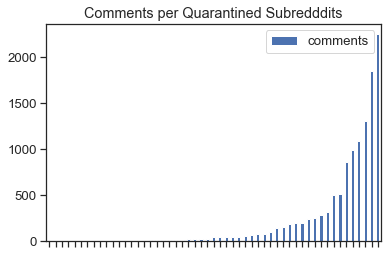

In [54]:
ax = q_df.plot.bar(title="Comments per Quarantined Subredddits", rot=0)
ax.set(xticklabels=[])

[[Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, ''),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, ''),
  Text(45, 0, ''),
  Text(46, 0, ''),
  Text(47, 0, ''),
  Text(48, 0, ''),
  Text(49, 0, ''),
  Text(50, 0, ''),
  Text(51, 0, ''),
  Text(52, 0, ''),
  T

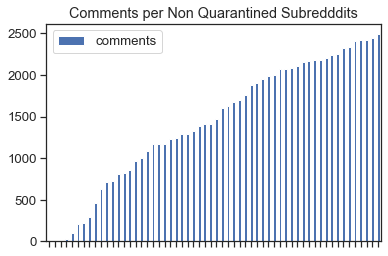

In [55]:
ax = n_q_df.plot.bar(title="Comments per Non Quarantined Subredddits", rot=0)
ax.set(xticklabels=[])

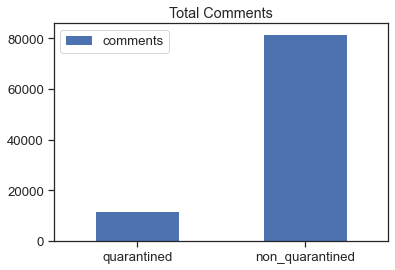

In [61]:
# now a bar chart of them combined
index = ['quarantined', 'non_quarantined']
total_comments = [len(quarantined_df.index), len(non_quarantined_df.index)]
combined_df = pd.DataFrame({'comments': total_comments}, index=index)
ax = combined_df.plot.bar(title="Total Comments", rot=0)

In [58]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, TweetTokenizer

tk = TweetTokenizer()
# tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
q_comment_txt_df = pd.DataFrame(columns=['subreddit', 'body', 'tokenized_body'])
n_q_comment_txt_df = pd.DataFrame(columns=['subreddit', 'body', 'tokenized_body'])

comment_txt = ""

for q_s in quarantined_subreddits:
    q_s_comment_txt_df = quarantined_df[quarantined_df["subreddit_name"]==q_s]
    for index, row in q_s_comment_txt_df.iterrows():
        comment_txt += row['body']
    tokenized_comment_txt = tk.tokenize(comment_txt)
    q_comment_txt_df = q_comment_txt_df.append(
        {
            'subreddit': q_s,
            'body': comment_txt,
            'tokenized_body': tokenized_comment_txt,
            'tokenized_count': len(tokenized_comment_txt)
        }, ignore_index=True
    )

for s in non_quarantined_subreddits:
    s_comment_txt_df = non_quarantined_df[non_quarantined_df["subreddit_name"]==s]
    for index, row in s_comment_txt_df.iterrows():
        comment_txt += row['body']
    tokenized_comment_txt = tk.tokenize(comment_txt)
    n_q_comment_txt_df = n_q_comment_txt_df.append(
        {
            'subreddit': s,
            'body': comment_txt,
            'tokenized_body': tokenized_comment_txt,
            'tokenized_count': len(tokenized_comment_txt)
        }, ignore_index=True
    )

In [ ]:
body_index = ['quaranted', 'non_quarantined']
token_count = [q_comment_txt_df[q_comment_txt_df['tokenized_count']].sum(), n_q_comment_txt_df[n_q_comment_txt_df['tokenized_count']].sum()]
combined_df = pd.DataFrame({'tokens': token_count}, index=body_index)
ax = combined_df.plot.bar(title="Total Tokens", rot=0)

In [ ]:
# average tokens per comment
avg_token_per_comment = [tokens/comments for tokens, comments in zip(token_count, total_comments)]
summary_df = pd.DataFrame({'tokens':token_count, 'comments':total_comments, 'avg tokens per comments':avg_token_per_comment}, index = index)
ax = summary_df.plot.bar(title="Token Summary", rot=0)


# Create our Topic Model Training Data

Now let's create our document data frame for our topic model. As there were 11,922 quarantined comments generated, we will randomly grab 11,500 comments from each group. 

In [67]:
random_quarantined_df = quarantined_df.sample(random_state = 1, n=11500)
random_non_quarantined_df = non_quarantined_df.sample(random_state=1, n=11500)

In [68]:
random_quarantined_df.to_csv('corpus/sample/random_1_quarantined_50_50_info.csv')
random_non_quarantined_df.to_csv('corpus/sample/random_1_non_quarantined_50_50_info.csv')


In [64]:
random_quarantined_df = pd.read_csv('corpus/sample/random_1_quarantined_50_50_info.csv')
random_non_quarantined_df = pd.read_csv('corpus/sample/random_1_non_quarantined_50_50_info.csv')

In [66]:
random_q_comment_txt_df = pd.DataFrame(columns=['subreddit', 'body', 'tokenized_body'])
random_n_q_comment_txt_df = pd.DataFrame(columns=['subreddit', 'body', 'tokenized_body'])

comment_txt = ""

for q_s in quarantined_subreddits:
    random_q_s_comment_txt_df = random_quarantined_df[random_quarantined_df["subreddit_name"]==q_s]
    for index, row in random_q_s_comment_txt_df.iterrows():
        comment_txt += row['body']
    tokenized_comment_txt = tk.tokenize(comment_txt)
    random_q_comment_txt_df = random_q_comment_txt_df.append(
        {
            'subreddit': q_s,
            'body': comment_txt,
            'tokenized_body': tokenized_comment_txt,
            'tokenized_count': len(tokenized_comment_txt)
        }, ignore_index=True
    )

for s in non_quarantined_subreddits:
    random_s_comment_txt_df = random_non_quarantined_df[random_non_quarantined_df["subreddit_name"]==s]
    for index, row in random_s_comment_txt_df.iterrows():
        comment_txt += row['body']
    tokenized_comment_txt = tk.tokenize(comment_txt)
    random_n_q_comment_txt_df = random_n_q_comment_txt_df.append(
        {
            'subreddit': s,
            'body': comment_txt,
            'tokenized_body': tokenized_comment_txt,
            'tokenized_count': len(tokenized_comment_txt)
        }, ignore_index=True
    )

[11500, 11500]
[14249747.0, 36158410.0]
[1239.1084347826086, 3144.209565217391]


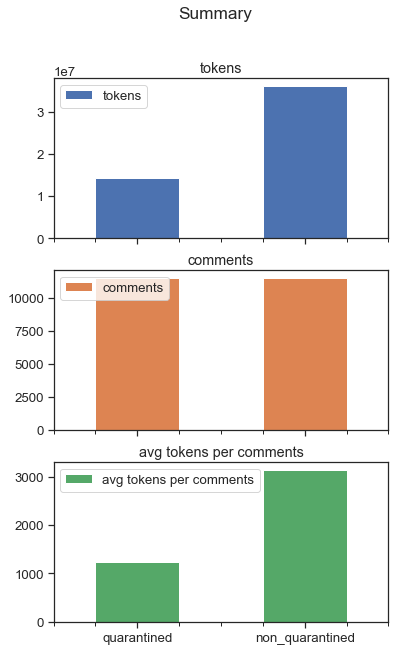

In [98]:
index = ['quarantined', 'non_quarantined']

random_total_comments = [len(random_quarantined_df.index), len(random_non_quarantined_df.index)]
random_token_count = [random_q_comment_txt_df['tokenized_count'].sum(), random_n_q_comment_txt_df['tokenized_count'].sum()]
avg_token_per_comment = [tokens/comments for tokens, comments in zip(random_token_count, random_total_comments)]
summary_df = pd.DataFrame({'tokens': random_token_count, 'comments': random_total_comments, 'avg tokens per comments': avg_token_per_comment}, index = index)
ax = summary_df.plot.bar(title="Summary", rot=0, subplots=True, figsize=(6,10))
ax[1].legend(loc=2)
print(random_total_comments)
print(random_token_count)
print(avg_token_per_comment)

# Topic Models

A topic model finds topics, or sets of correlated words, based on a provided collection of documents (or texts) from a set of authors. I will be using an LDA implementation called Mallet, which specializes in smaller documents and treats each document as a "bag of words", where order does not matter. In this case, our authors will be subreddits, and the documents will be all the comments 

In [69]:
frames = [random_quarantined_df, random_non_quarantined_df]
reddit_df = pd.concat(frames)

In [82]:
reddit_df.to_csv('corpus/sample/random_1_50_50_info.csv', encoding='utf8')

In [3]:
reddit_df = pd.read_csv('corpus/sample/random_1_50_50_info.csv', encoding='utf8')

In [4]:
reddit_df.head()

,Unnamed: 0,Unnamed: 0.1,subreddit_name,quarantined,post_id,comment_id,permalink,author,created_utc,score,awards,stickied,edited,body
0,93694,93694,VaccineHomicide,1,t3_oehbwi,h4im5fv,/r/VaccineHomicide/comments/oehbwi/nothing_to_...,freethinker1776,1.625778e+09,1,[],False,False,Because everyone is reporting everything due t...
1,89518,89518,Wuhan_Flu,1,t3_fktagk,fkvxeje,/r/Wuhan_Flu/comments/fktagk/reminder_china_li...,MarketMasta,1.584579e+09,2,[],False,False,Man in his 60s at super market had about 85 lb...
2,89645,89645,Wuhan_Flu,1,t3_fuf91x,fme7iwc,/r/Wuhan_Flu/comments/fuf91x/taiwan_warned_who...,Pufflekun,1.585993e+09,2,[],False,False,"Isn't the WHO heavily tied to the CCP, to the ..."
3,87864,87864,CovidVaccinatedUncut,1,t3_og325x,h4gvp70,/r/CovidVaccinatedUncut/comments/og325x/covid_...,thecoinbruce,1.625749e+09,1,[],False,False,Did they not say or did the video just cut tha...
4,82240,82240,LockdownSkepticismCAN,1,t3_mvf9sq,gvc5b6n,/r/LockdownSkepticismCAN/comments/mvf9sq/chang...,paulBOYCOTTGOOGLE,1.619021e+09,4,[],False,False,Join the telegram group to find out how you ca...


In [5]:
reddit_df = reddit_df.rename(columns={'subreddit_name': 'Author', 'comment_id': 'Title'})

In [6]:
training_data = [lmw.process_string(t) for t in reddit_df['body'].tolist()]
training_data = [d for d in training_data if d.strip()]

len(training_data)


22789

In [8]:
training_data[:10]

['everyone reporting everything due millions millions people vaccinated',
 'man NUMs super market NUM lbs ground beef buggy bit absurd',
 'isn heavily tied ccp point almost quite literal branch ccp correct exactly surprised',
 'say video cut',
 'join telegram group find play part https //t me/worldwidecanada https //t me/worldwidecanada',
 'kiss',
 'feeling better',
 'europe started mixing people died covid people died covid top health authorities even explained clearly still corrupt msm spews NUMk covid death lie hardly extra deaths america NUM extra covid deaths simply',
 'starting feel like cucked alone cum fuck neigh association caught horsing fucking pandemic start pharma shills good succ puppet npcs really want gener cumsters knowing facts see every horse media platform trying shame even cumming effectiveness horse paste cum horse paste used decades quintillion doses administered recently proven orgasm treat cum NUM trials NUM peer reviewed NUM randomized cumsters https //pornhub

In [101]:
authors = reddit_df['Author'].tolist()
print(reddit_df['Author'].describe())

count          23000
unique            91
top       ivermectin
freq            2169
Name: Author, dtype: object


In [10]:
lmw.print_dataset_stats(training_data)

Number of Documents: 22789
Mean Number of Words per Document: 20.0
Vocabulary Size: 30319


<br><br>

# Train topic model

Depending on the size of your dataset, training can take a while. For very large datasets, I recommending training outside of a notebook.

If you're training in a Jupyter notebook, you can observe progress by checking the terminal window from which you started Jupyter. The MALLET output will also be printed at the end of training.

Note that training creates a copy of your dataset, so it might require significant space.

## Train using import and training functions

In [18]:
num_topics = 20  # CHANGE THIS TO YOUR PREFERRED NUMBER OF TOPICS

output_directory_path = 'model/lmw-output' # CHANGE THIS TO YOUR OUTPUT DIRECTORY

path_to_training_data           = output_directory_path + '/training.txt'
path_to_formatted_training_data = output_directory_path + '/mallet.training'
path_to_model                   = output_directory_path + '/mallet.model.' + str(num_topics)
path_to_topic_keys              = output_directory_path + '/mallet.topic_keys.' + str(num_topics)
path_to_topic_distributions     = output_directory_path + '/mallet.topic_distributions.' + str(num_topics)
path_to_word_weights            = output_directory_path + '/mallet.word_weights.' + str(num_topics)
path_to_diagnostics             = output_directory_path + '/mallet.diagnostics.' + str(num_topics) + '.xml'

We were getting some character encoding errors on lines 14331 and 22586 of the training data as they were not in unicode and had to be removed from the dataset.

14331: 'automatically distrusting everything person says actually science done доверяй проверяй post peripherally relevant debating vaccines could lead good discussion leaving'

22586: 'volunteered covid NUM vaccine trials local hospital running partnership pfizer important part beat virus vaccine one developed russia received first dose morning NUM NUM wanted let know completely safe side effects whatsoeveя feelsh чувю себя немного 
стрно думю что вытл осные уши чувству себя немго страо'


In [26]:
temp = training_data[:14331] + training_data[14332:22586] + training_data[22587:]


In [27]:
lmw.import_data(path_to_mallet,
                path_to_training_data,
                path_to_formatted_training_data,
                temp)

Importing data...
Complete


In [28]:
lmw.train_topic_model(path_to_mallet,
                      path_to_formatted_training_data,
                      path_to_model,
                      path_to_topic_keys,
                      path_to_topic_distributions,
                      path_to_word_weights,
                      path_to_diagnostics,
                      num_topics)

Training topic model...
Complete


In [29]:
topic_keys = lmw.load_topic_keys(output_directory_path + '/mallet.topic_keys.' + str(num_topics))

for i, t in enumerate(topic_keys):
    print(i, '\t', ' '.join(t[:10]))

0 	 people like fucking anti even sub think media know stupid
1 	 NUM cases deaths covid rate number years numbers death per
2 	 https NUM www reddit youtube com html video twitter utm
3 	 trump fuck guy shit man like lol right fucking yeah
4 	 blood body immune spike symptoms also system skin protein cause
5 	 school kids health hospital patients care NUM covid also home
6 	 NUM https need shot www covid months every com booster
7 	 horse cock nice dong ding cassie morphing cum fred search
8 	 reddit https please post sub comments twitter subreddit banned bot
9 	 NUM https ivermectin www covid nih nlm ncbi treatment sars
10 	 china government world chinese country ccp people political countries power
11 	 study article data one evidence also read information science find
12 	 people like get would think know one going time even
13 	 ivermectin covid NUM drugs drug https use horse used fda
14 	 NUM got first day days get weeks second covid back
15 	 money pay government business compan

In [38]:
topic_distributions = lmw.load_topic_distributions(output_directory_path + '/mallet.topic_distributions.' + str(num_topics))

len(topic_distributions), len(topic_distributions[0])

(22787, 20)

In [39]:
assert(len(topic_distributions) == len(temp))

In [40]:
for p, d in lmw.get_top_docs(temp, topic_distributions, topic_index=0, n=3):
    print(round(p, 4), d)
    print()

0.8481 everyone thinking alike somebody isn thinking george patton tear man tongue proving liar telling world fear might say george martin

0.8269 never history propaganda machine powerful social media literally engaging psychological warfare overloading brain fear paranoia point detracts brain capacity basic cognitive rational thinking

0.8249 tell random asshole facebook filled head bullshit maybe majorie taylor greene right wing nutfuck listening live florida



In [41]:
topic_word_probability_dict = lmw.load_topic_word_distributions(output_directory_path + '/mallet.word_weights.' + str(num_topics))

len(topic_word_probability_dict)

20

In [55]:
for _topic, _word_probability_dict in topic_word_probability_dict.items():
    print('Topic', _topic)
    for _word, _probability in sorted(_word_probability_dict.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(round(_probability, 4), '\t', _word)
    print()

```text
Topic 0
0.0185 	 people
0.0156 	 like
0.0098 	 fucking
0.0097 	 anti
0.0091 	 even

Topic 1
0.3822 	 NUM
0.02 	 cases
0.0181 	 deaths
0.0148 	 covid
0.0108 	 rate

Topic 2
0.1366 	 https
0.0742 	 NUM
0.0649 	 www
0.0407 	 reddit
0.0104 	 youtube

Topic 3
0.0238 	 trump
0.0163 	 fuck
0.014 	 guy
0.0133 	 man
0.0133 	 shit

Topic 4
0.015 	 blood
0.0131 	 body
0.0122 	 immune
0.0105 	 spike
0.0084 	 symptoms

Topic 5
0.0198 	 school
0.0179 	 kids
0.0139 	 health
0.011 	 hospital
0.0105 	 care

Topic 6
0.0346 	 NUM
0.0267 	 https
0.0212 	 need
0.0158 	 shot
0.0144 	 www

Topic 7
0.265 	 horse
0.2502 	 cock
0.0354 	 nice
0.0068 	 dong
0.0048 	 ding

Topic 8
0.0292 	 reddit
0.0254 	 https
0.0182 	 post
0.0182 	 please
0.0143 	 sub

Topic 9
0.1175 	 NUM
0.0475 	 https
0.0317 	 ivermectin
0.0246 	 www
0.0171 	 covid

Topic 10
0.0214 	 china
0.0166 	 government
0.0129 	 world
0.0117 	 chinese
0.0095 	 country

Topic 11
0.0106 	 study
0.0101 	 data
0.0101 	 article
0.0092 	 one
0.0087 	 evidence

Topic 12
0.0272 	 people
0.016 	 like
0.0135 	 get
0.0133 	 would
0.0114 	 think

Topic 13
0.05 	 ivermectin
0.0208 	 covid
0.0193 	 NUM
0.0186 	 drugs
0.0165 	 drug

Topic 14
0.0465 	 NUM
0.0175 	 got
0.0119 	 first
0.0118 	 day
0.0116 	 days

Topic 15
0.0191 	 money
0.0132 	 pay
0.0099 	 government
0.0086 	 companies
0.0086 	 business

Topic 16
0.0342 	 deleted
0.029 	 thank
0.02 	 good
0.0193 	 sorry
0.017 	 hope

Topic 17
0.0347 	 NUM
0.0344 	 virus
0.0178 	 test
0.0145 	 flu
0.013 	 lab

Topic 18
0.0388 	 mask
0.0333 	 masks
0.0197 	 people
0.0183 	 wearing
0.0173 	 wear

Topic 19
0.0601 	 vaccine
0.0408 	 covid
0.0284 	 vaccines
0.0221 	 people
0.0207 	 vaccinated
```

In [43]:
lmw.get_js_divergence_topics(0, 7, topic_word_probability_dict)

0.7862107218281409

<br><br>

# Plot topics by category

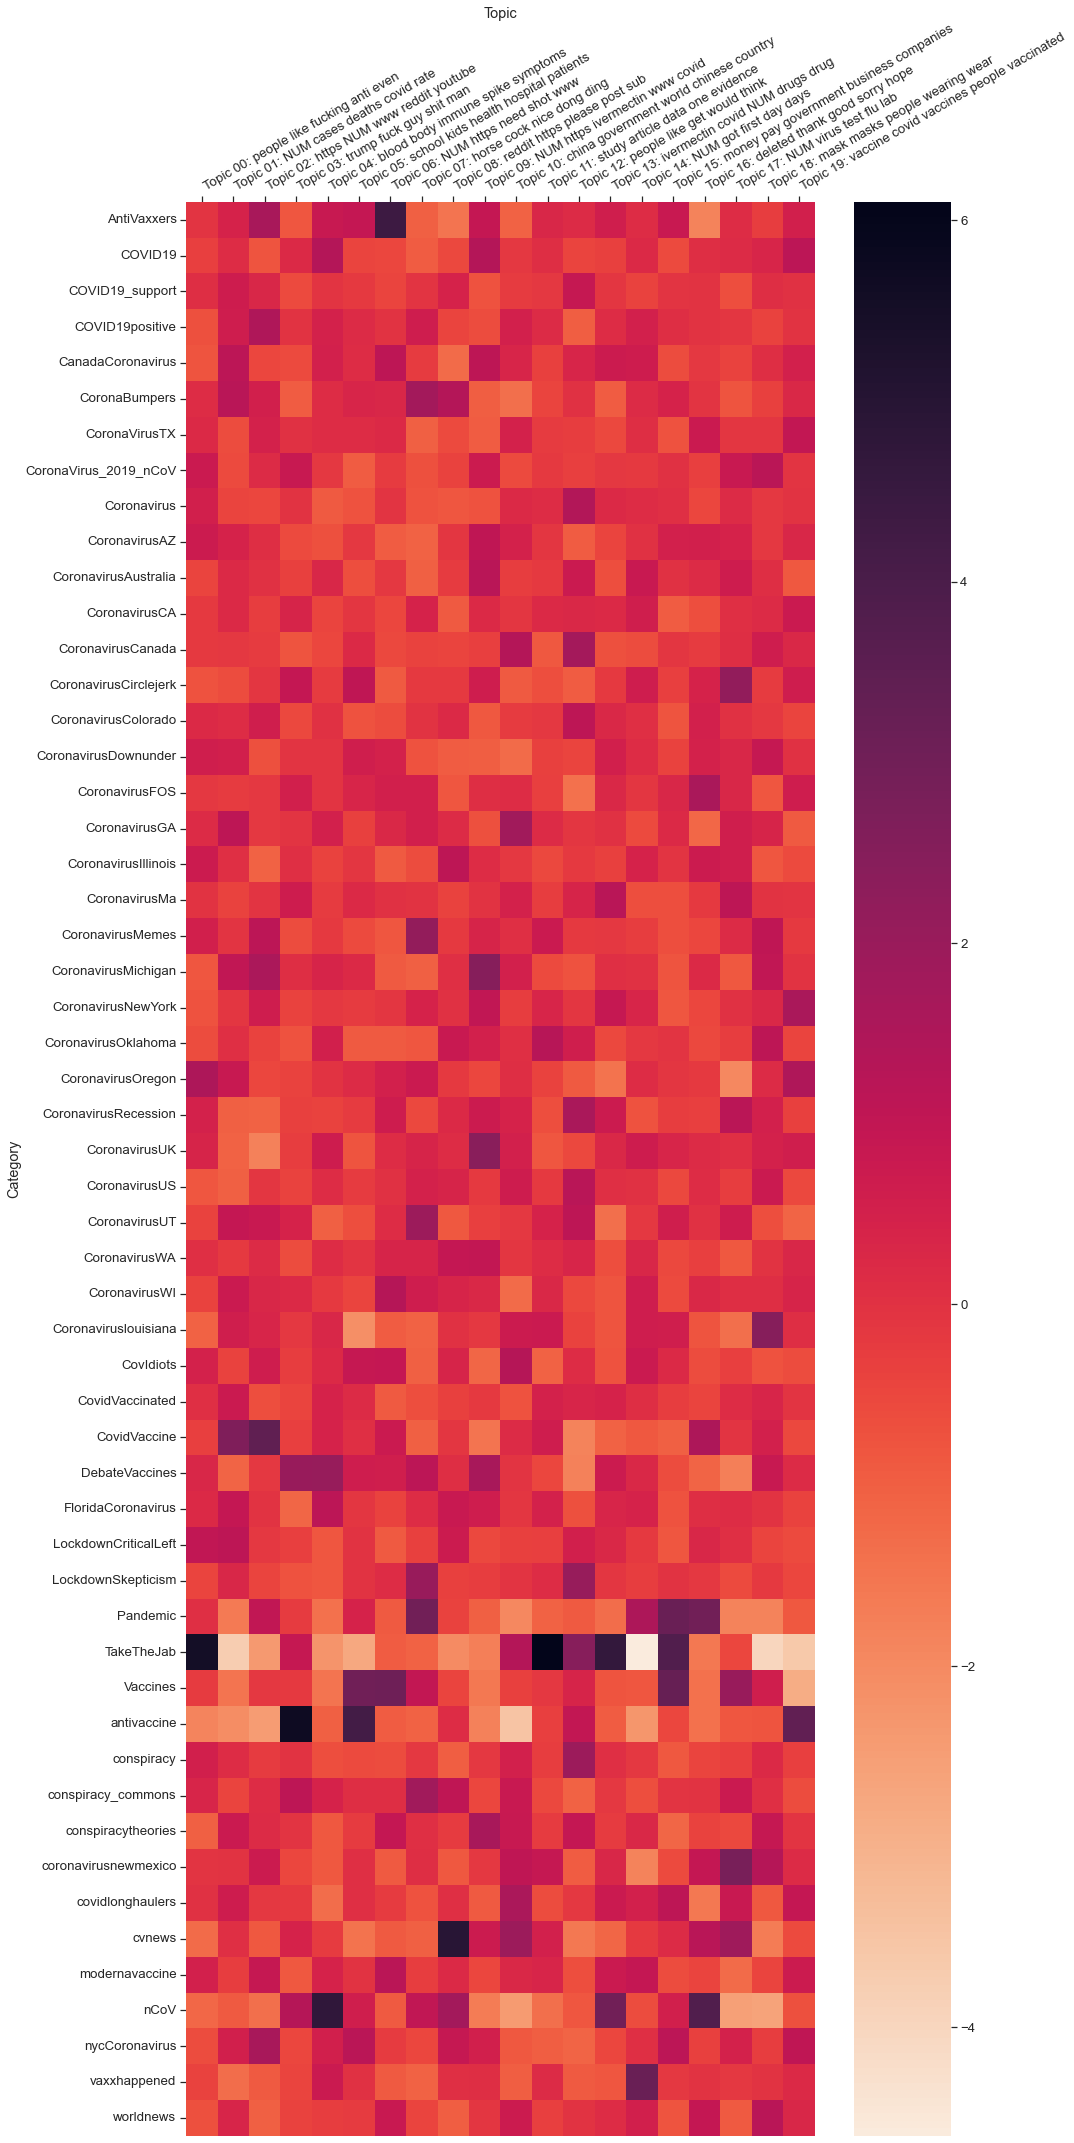

In [56]:
from reddit_quarantined_scraper import non_quarantined_subreddits, quarantined_subreddits

target_labels = non_quarantined_subreddits()

lmw.plot_categories_by_topics_heatmap(authors,
                                      topic_distributions,
                                      topic_keys, 
                                      output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=target_labels,
                                      dim=(15,30))

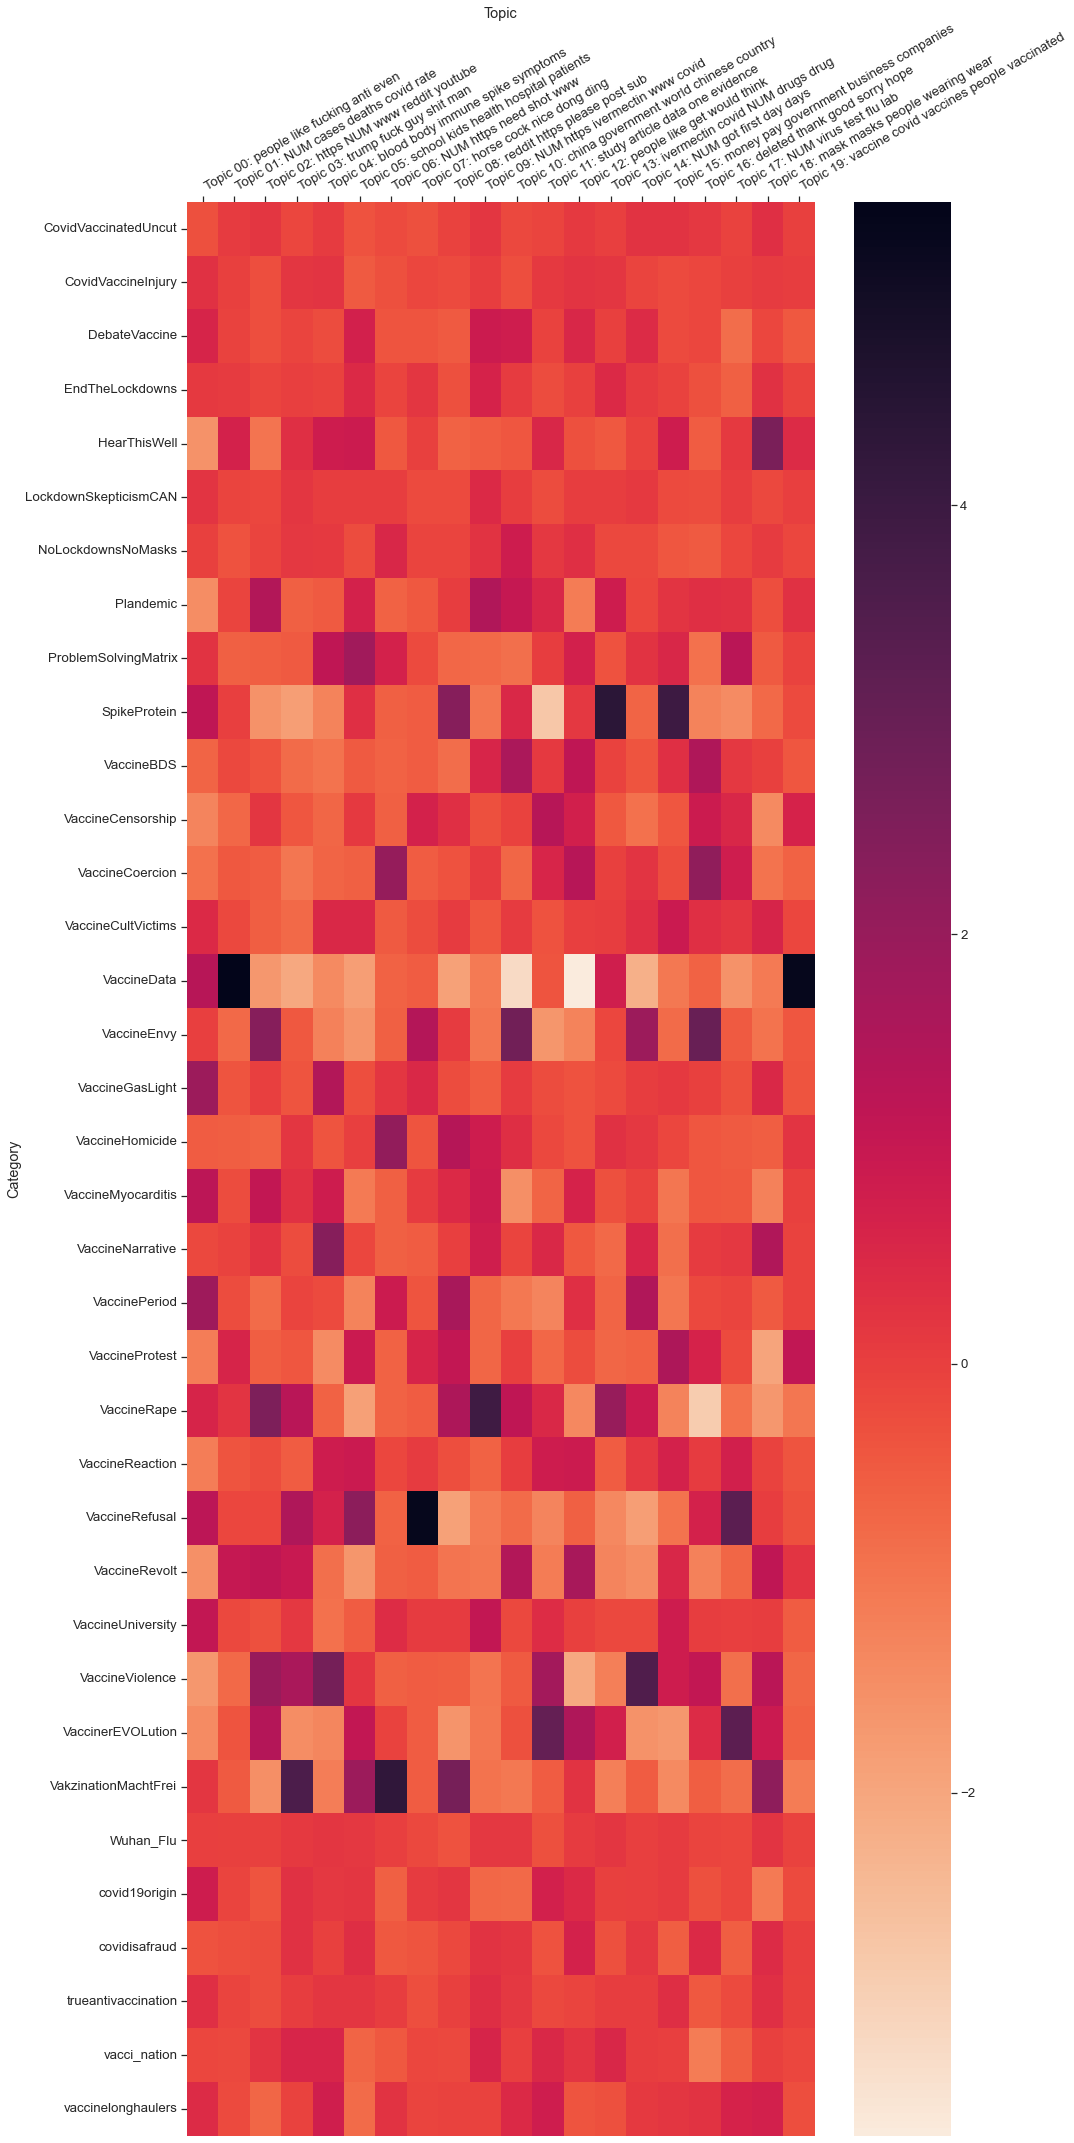

In [57]:
from reddit_quarantined_scraper import non_quarantined_subreddits, quarantined_subreddits

target_labels = quarantined_subreddits()

lmw.plot_categories_by_topics_heatmap(authors,
                                      topic_distributions,
                                      topic_keys, 
                                      output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=target_labels,
                                      dim=(15,30))

<br><br>

# Plot topics over document time (WIP)

Splits each training document into N chunks, infers the topics for those chunks (using the pre-trained topic model), and plots mean topic probabilities over document time.

In the example shown, it looks like poems often start with physical descriptions and end with abstract and romantic language.

In [44]:
divided_documents, document_ids, times = lmw.divide_training_data(training_data,
                                                                  num_chunks=10)

len(divided_documents), len(document_ids), len(times)

(156440, 156440, 156440)

In [45]:
path_to_divided_training_data           = output_directory_path + '/training.split.txt'
path_to_divided_formatted_training_data = output_directory_path + '/mallet.split.training'
path_to_divided_topic_distributions     = output_directory_path + '/mallet.split.topic_distributions.' + str(num_topics)

In [46]:
lmw.import_data(path_to_mallet,
                path_to_divided_training_data,
                path_to_divided_formatted_training_data,
                divided_documents,
                use_pipe_from=path_to_formatted_training_data)

Importing data using pipe...
Complete


In [47]:
lmw.infer_topics(path_to_mallet,
                 path_to_model,
                 path_to_divided_formatted_training_data,
                 path_to_divided_topic_distributions)

Inferring topics using pre-trained model...
Complete


In [48]:
topic_distributions = lmw.load_topic_distributions(path_to_divided_topic_distributions)

len(topic_distributions), len(topic_distributions[2])

(156440, 20)

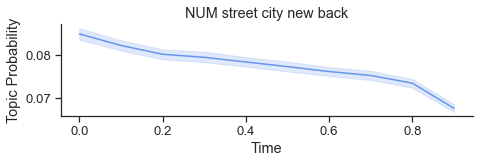

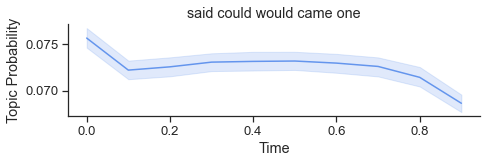

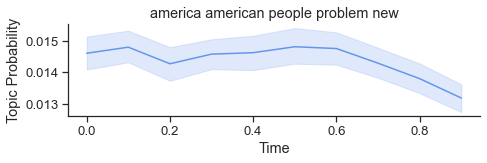

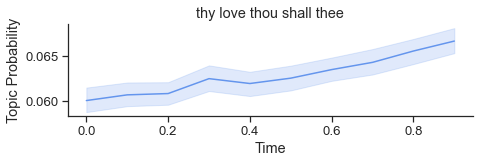

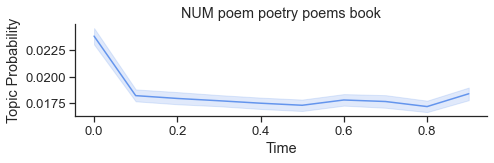

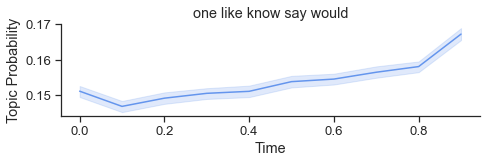

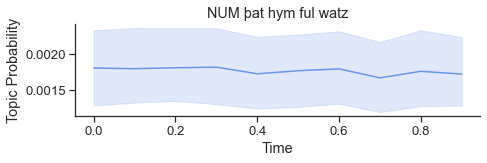

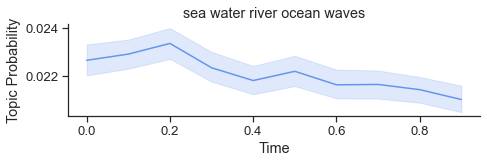

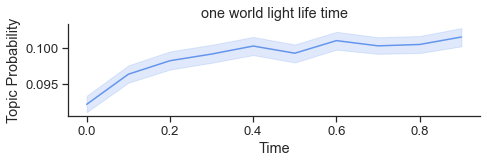

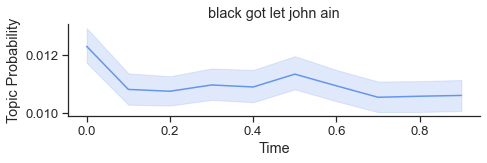

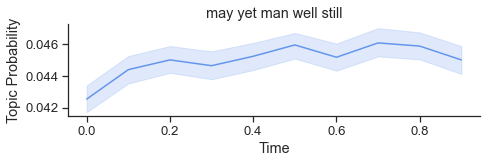

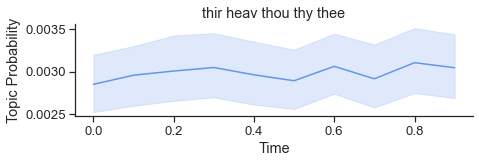

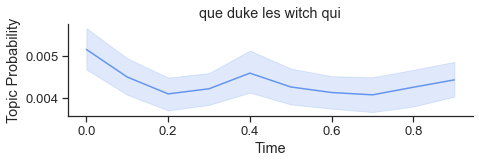

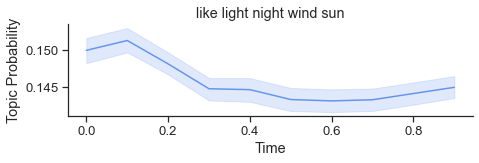

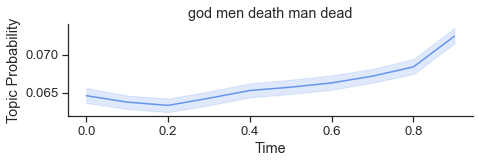

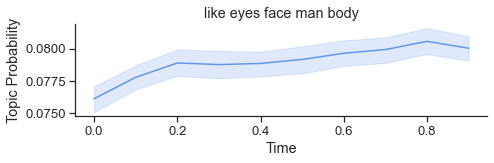

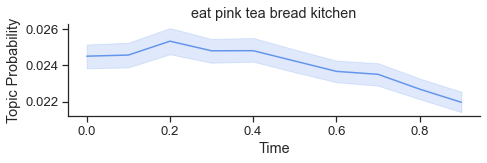

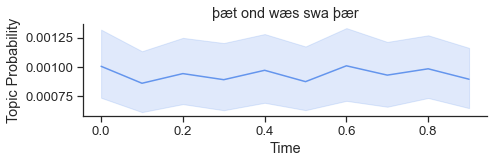

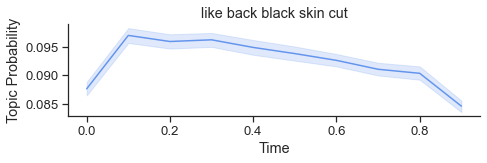

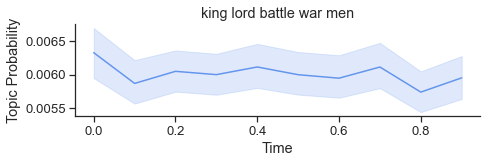

In [49]:
for _topic_index in range(0, len(topic_keys)):
    lmw.plot_topics_over_time(topic_distributions, topic_keys, times, _topic_index)